#  Прогнозирование заказов такси

**Цель проекта**: построить модель для прогнозирования количества заказов такси на следующий час со значением метрики RMSE на тестовой выборке не больше 48.

**Шаги проекта**:
- подготовка данных и ресемплирование по одному часу;
- анализ данных,
- обучение моделей;
- тестирование моделей;
- выводы.

## Подготовка

In [157]:
import pandas as pd

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

### Загрузка и обработка данных.

In [159]:
data = pd.read_csv('/datasets/taxi.csv',  parse_dates=[0], index_col=[0])

In [160]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У столбца с датой и временем выявлен несоответствующий тип данных, передадим в функцию read_csv() новый аргумент parse_dates.

Проверим, в хронологическом ли порядке расположены данные в столбце с датой и временем, для этого удалим столбец с индексами аргументом index_col).

In [162]:
data.index.is_monotonic

True

Хронологический порядок соблюден.

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Таким образом, мы располагаем данными с 1 марта 2018 года по 31 августа 2018 года

Построим график временного ряда.

<AxesSubplot:title={'center':'Исходные данные'}, xlabel='datetime'>

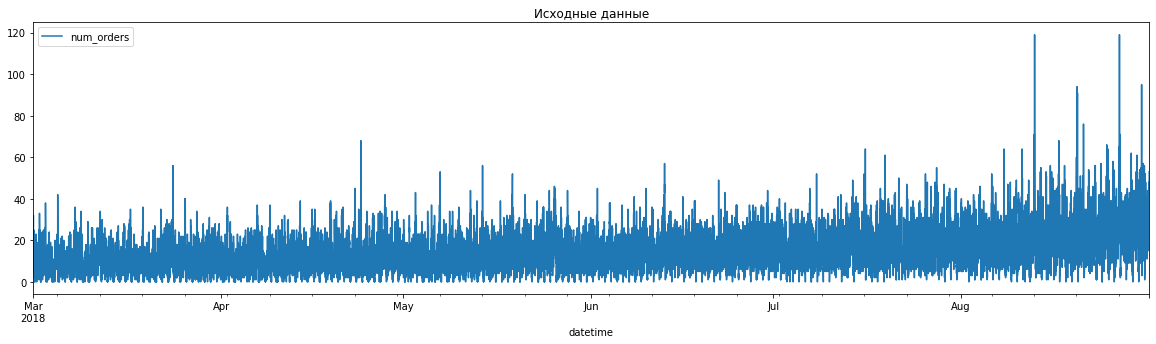

In [164]:
data.plot(figsize=(20, 5), title="Исходные данные",)

### Выполним ресемплирование данных по одному часу.

In [165]:
data_re = data.resample('1H').sum()

<AxesSubplot:title={'center':'Ресемплирование по одному часу'}, xlabel='datetime'>

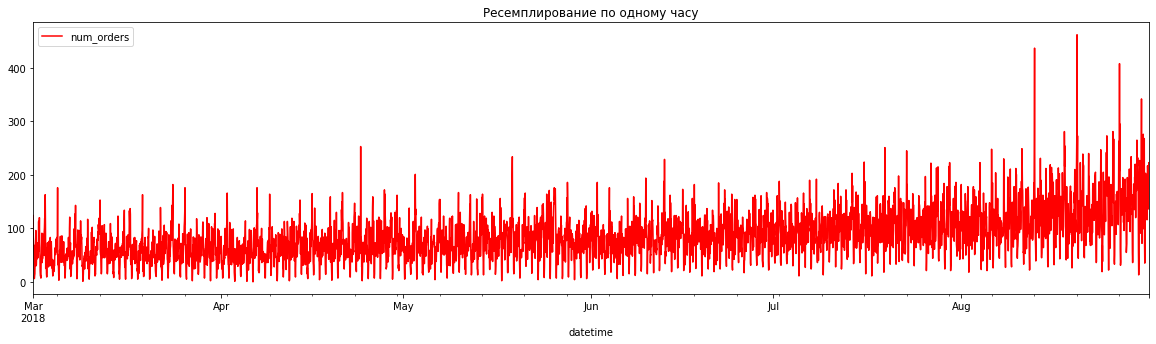

In [166]:
data_re.plot(figsize=(20, 5), title="Ресемплирование по одному часу", color='red')

Выводы: 
   - у столбца с датой и временем выявлен несоответствующий тип данных, данные преобразованы в форматы даты и времени;
   - данные расположены в хронологическом порядке;
   - мы располагаем данными с 1 марта 2018 года по 31 августа 2018 года,
   - выполнено ресемплирование данных по одному часу.

## Анализ

### Снизим колебания временного ряда.

Чтобы во временном ряду снизить колебания, применим скользящее среднее от 6 значений (то есть за каждые 6 часов).

In [167]:
data_re['rolling_mean'] = data_re.shift().rolling(6).mean()

In [168]:
data_re.head(10)

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,65.833333
2018-03-01 07:00:00,15,47.166667
2018-03-01 08:00:00,34,35.500000


<AxesSubplot:title={'center':'Скользящее среднее'}, xlabel='datetime'>

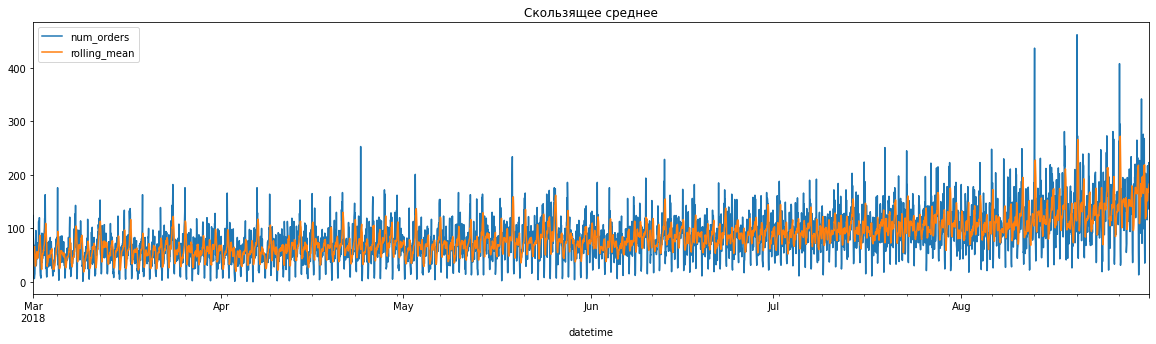

In [169]:
data_re.plot(figsize=(20, 5), title="Скользящее среднее")

### Изучим колебания за март месяц и за август месяц

In [170]:
data_march = data_re['2018-03-01':'2018-03-31']

<AxesSubplot:title={'center':'Скользящее среднее за март 2018'}, xlabel='datetime'>

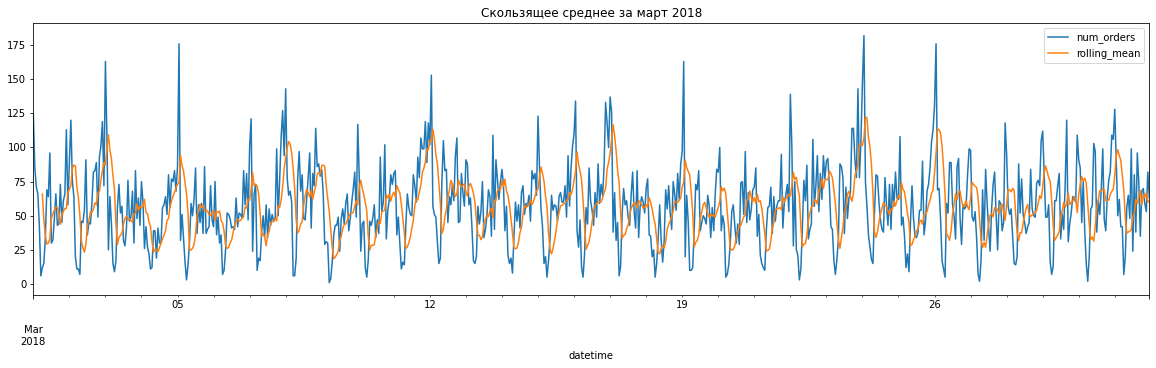

In [171]:
data_march.plot(figsize=(20, 5), title="Скользящее среднее за март 2018")

In [172]:
data_august = data_re['2018-08-01':'2018-08-31']

<AxesSubplot:title={'center':'Скользящее среднее за август 2018'}, xlabel='datetime'>

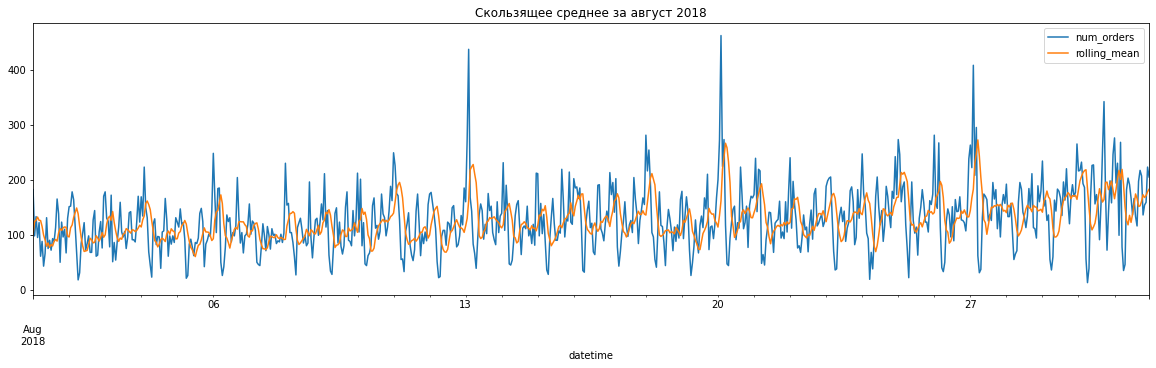

In [173]:
data_august.plot(figsize=(20, 5), title="Скользящее среднее за август 2018")

### Изучим недельные колебания

In [174]:
data_april_week = data_re['2018-04-01':'2018-04-08']

<AxesSubplot:title={'center':'Скользящее среднее за первую неделю апреля 2018'}, xlabel='datetime'>

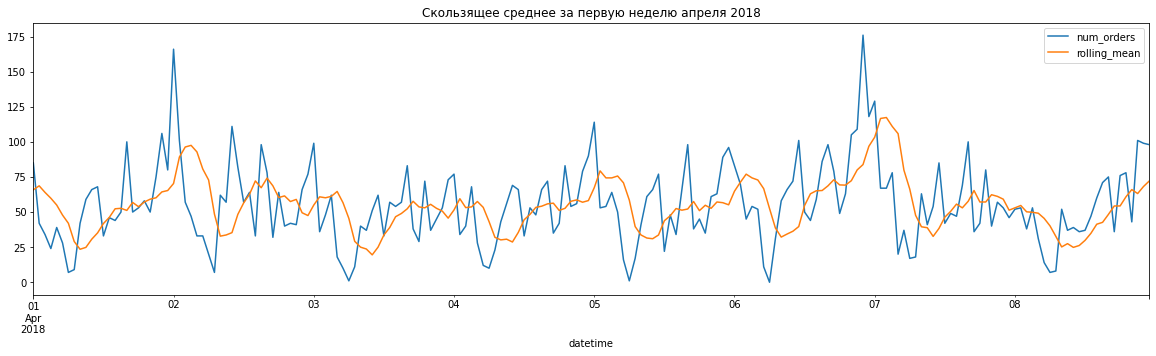

In [175]:
data_april_week.plot(figsize=(20, 5), title="Скользящее среднее за первую неделю апреля 2018")

### Изучим дневные колебания на неделе (3 апреля - вторник)

In [176]:
data_april_3 = data_re['2018-04-03':'2018-04-03']

<AxesSubplot:title={'center':'Скользящее среднее за 3 апреля 2018'}, xlabel='datetime'>

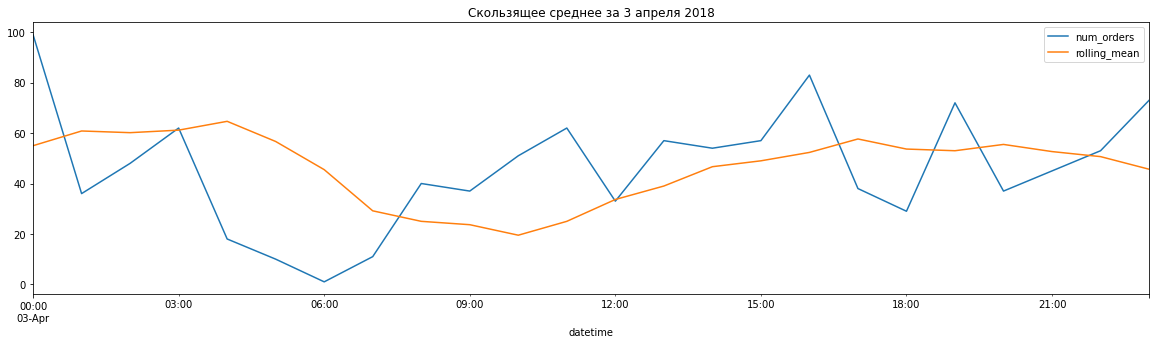

In [177]:
data_april_3.plot(figsize=(20, 5), title="Скользящее среднее за 3 апреля 2018")

### Изучим дневные колебания с пятницы по воскресенье включительно (6 - 8 апреля)

In [178]:
data_april_6_8 = data_re['2018-04-06':'2018-04-08']

<AxesSubplot:title={'center':'Скользящее среднее за 6-8 апреля 2018'}, xlabel='datetime'>

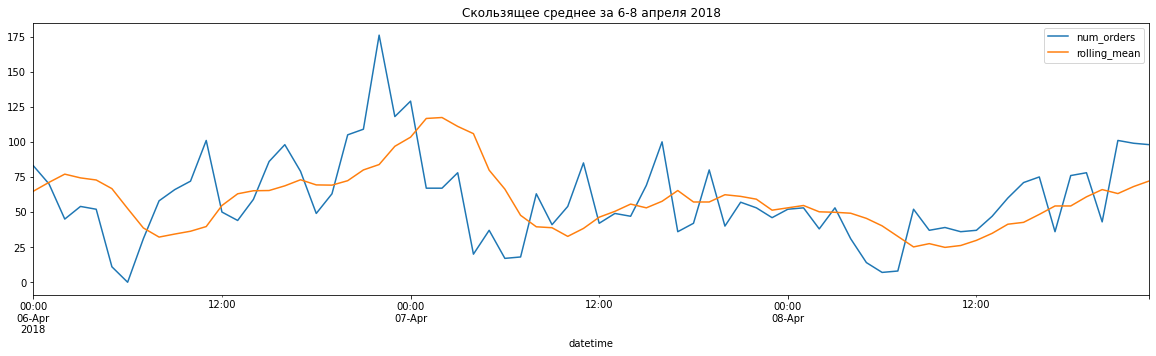

In [179]:
data_april_6_8.plot(figsize=(20, 5), title="Скользящее среднее за 6-8 апреля 2018")

### Изучим сезонные колебания

In [180]:
data_spring = data_re['2018-03':'2018-05']
data_summer = data_re['2018-06':'2018-08']

<AxesSubplot:title={'center':'Скользящее среднее весна 2018'}, xlabel='datetime'>

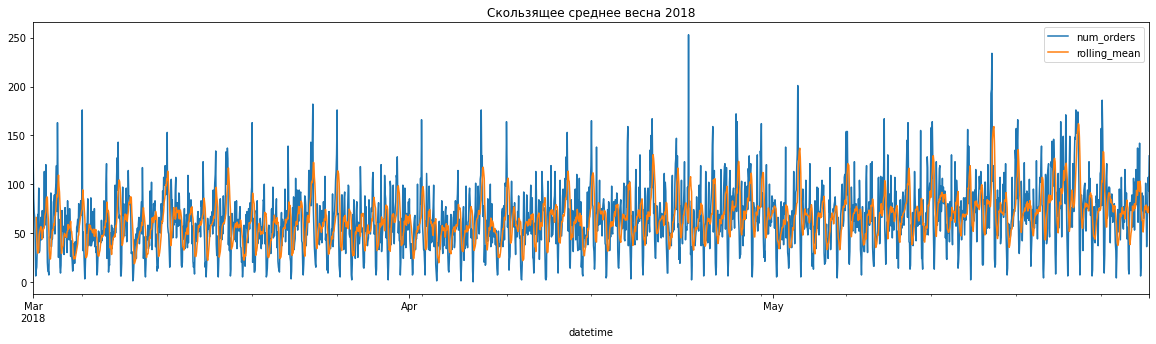

In [181]:
data_spring.plot(figsize=(20, 5), title="Скользящее среднее весна 2018")

<AxesSubplot:title={'center':'Скользящее среднее лето 2018'}, xlabel='datetime'>

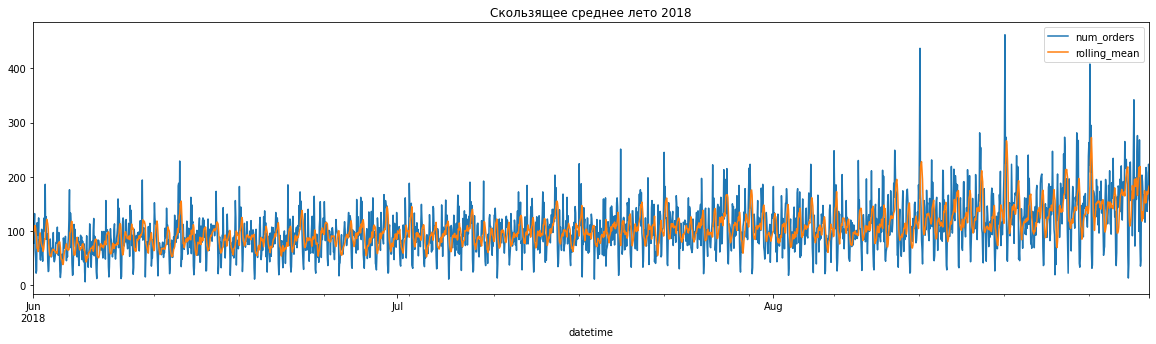

In [182]:
data_summer.plot(figsize=(20, 5), title="Скользящее среднее лето 2018")

### Проведем сезонную декомпозицию, построим графики тренда и сезонности

In [214]:
data_days = data.resample('1H').sum()
decomposed = seasonal_decompose(data_days)

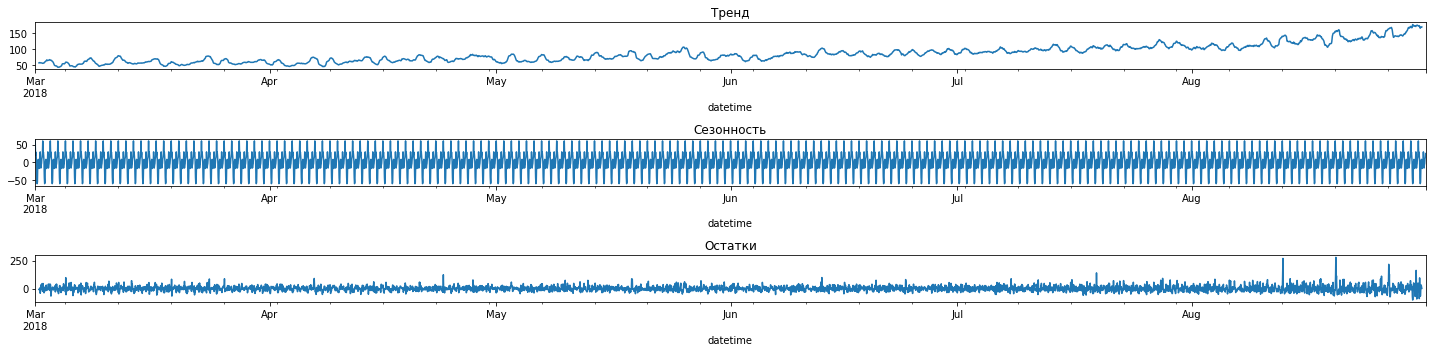

In [219]:
plt.figure(figsize=(20, 5))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

График тренда показывает, что среднее значение заказов такси увеличивается с начала матра до конца августа.

Text(0.5, 1.0, 'Апрель 1-07')

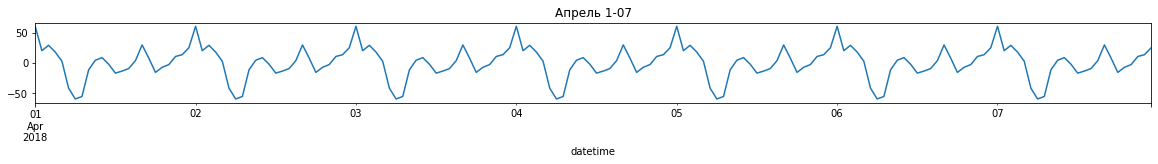

In [223]:
plt.figure(figsize=(20, 5))
plt.subplot(311)
season = decomposed.seasonal['2018-04-01':'2018-04-07'].resample('1H').sum()
season.plot(ax=plt.gca())
plt.title('Апрель 1-07')

Text(0.5, 1.0, 'Апрель 1-30')

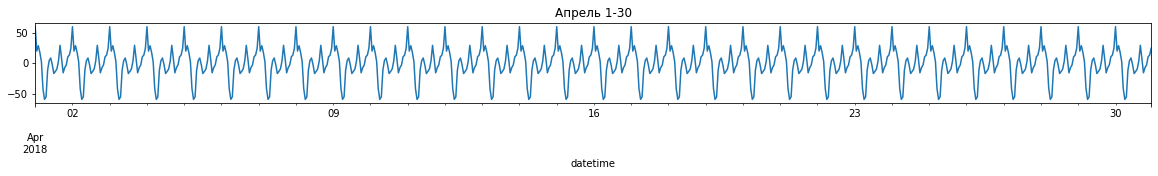

In [226]:
plt.figure(figsize=(20, 5))
plt.subplot(311)
season = decomposed.seasonal['2018-04-01':'2018-04-30'].resample('1H').sum()
season.plot(ax=plt.gca())
plt.title('Апрель 1-30')

Таким образом, мы видим, что в течение недели/месяца существует видимая тенденция с уменьшением заказов в ночные часы и увеличением в течение дня.

### Выводы

Таким образом, проанализировав данные мы выделелили следующие особенности:
- существует разница в объемах заказов такси по сезонам, меcяцам, неделям, дням недели, времени суток;
- среднее значение заказов такси увеличивается с начала матра до конца августа;
- в течение недели/месяца существует видимая тенденция с уменьшением заказов в ночные часы и увеличением в течение дня.

Имеющиеся данные представляют собой стационарный временной ряд - его распределение не зависит от времени.

## Обучение

### Создадим признаки

In [187]:
def make_features(data_re, max_lag):
    data_re['month'] = data_re.index.month
    data_re['day'] = data_re.index.day
    data_re['dayofweek'] = data_re.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data_re['lag_{}'.format(lag)] = data_re['num_orders'].shift(lag)

    return

make_features(data_re, 168)

In [188]:
data_re.head(5)

,num_orders,rolling_mean,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделим датасет на тренировочную и тестовую выборки, тестовую выборку определим размером 10 процентов.

In [189]:
train, test = train_test_split(data_re, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Удалим пропущенны значения.

In [190]:
train = train.dropna()
train.shape

(3806, 173)

In [191]:
test.shape

(442, 173)

In [192]:
train.head(5)

,num_orders,rolling_mean,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,92.333333,3,8,3,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,78,99.666667,3,8,3,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,65,104.333333,3,8,3,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-08 03:00:00,68,102.500000,3,8,3,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-08 04:00:00,60,95.833333,3,8,3,68.0,65.0,78.0,143.0,94.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


### Определим целевой признак

In [193]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Обучим модель линейная регрессия, вычислим метрику RMSE

In [194]:
model_lr = LinearRegression()

In [195]:
model_lr.fit(features_train, target_train)

LinearRegression()

In [196]:
predictions_lr= model_lr.predict(features_train) 
mrse_lr = sqrt(mean_squared_error(target_train, predictions_lr))
mrse_lr

20.332310619358985

In [197]:
print('LinearRegression', 'RMSE -', mrse_lr)

LinearRegression RMSE - 20.332310619358985


### Обучим модель дерева решений для регрессии, вычислим метрику RMSE

In [198]:
model_dtr = DecisionTreeRegressor(random_state=12345)
params_dtr={'max_depth': range(1, 50, 5),
               'min_samples_split': range(2, 12, 2),
               'min_samples_leaf':range(1, 10, 1),
               'max_features': ['auto', 'sqrt', 'log2'],
                           }
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

dtr = RandomizedSearchCV(model_dtr, params_dtr, n_iter=20, n_jobs=-1, cv=tscv)
dtr.fit(features_train, target_train)
model_dtr = dtr.best_estimator_
model_dtr

DecisionTreeRegressor(max_depth=31, max_features='auto', min_samples_leaf=9,
                      random_state=12345)

In [199]:
predictions_dtr= model_dtr.predict(features_train) 
mrse_dtr = sqrt(mean_squared_error(target_train, predictions_dtr))
mrse_dtr

14.291658573800845

In [200]:
print('DecisionTreeRegressor', 'RMSE -', mrse_dtr)

DecisionTreeRegressor RMSE - 14.291658573800845


### Обучим модель CatBoost, вычислим метрику RMSE

In [201]:
model_cbr = CatBoostRegressor(random_state=12345, loss_function= "RMSE", verbose = False)


grid = {'learning_rate': [0.03, 0.1],
        'depth': range(2, 6, 2),
        'l2_leaf_reg': range(1, 6, 2),
        'iterations': [19, 25, 50]}

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
cbr = RandomizedSearchCV(model_cbr, grid, n_iter=10, cv=tscv)
cbr.fit(features_train, target_train, plot=True)
best = cbr.best_estimator_
best_p = cbr.best_params_
print(best, best_p)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<catboost.core.CatBoostRegressor object at 0x7f4a7c1dab20> {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 50, 'depth': 4}


In [202]:
predictions= best.predict(features_train) 
mrse_cbr = sqrt(mean_squared_error(target_train, predictions))
mrse_cbr

20.412669412433644

In [203]:
print('CatBoostRegressor', 'RMSE -', mrse_cbr)

CatBoostRegressor RMSE - 20.412669412433644


Выводы:
Таким образом мы получили следующие показатели метрики качества для исследуемых моделей:

In [204]:
print('LinearRegression', 'RMSE -', mrse_lr)
print('DecisionTreeRegressor', 'RMSE -', mrse_dtr)
print('CatBoostRegressor', 'RMSE -', mrse_cbr)

LinearRegression RMSE - 20.332310619358985
DecisionTreeRegressor RMSE - 14.291658573800845
CatBoostRegressor RMSE - 20.412669412433644


Наилучшиий показатель RMSE у модели CatBoostRegressor - 20,01

## Тестирование

Проверим модель CatBoostRegressor на тестовой выбоке

In [205]:
predictions_cbr1= best.predict(features_test) 
mrse_cbr1 = sqrt(mean_squared_error(target_test, predictions_cbr1))
mrse_cbr1

39.18532059325702

Таким образом, модель соответсвует требуемым заказчиком критериям.

<AxesSubplot:title={'center':'Предсказанные моделью данные'}>

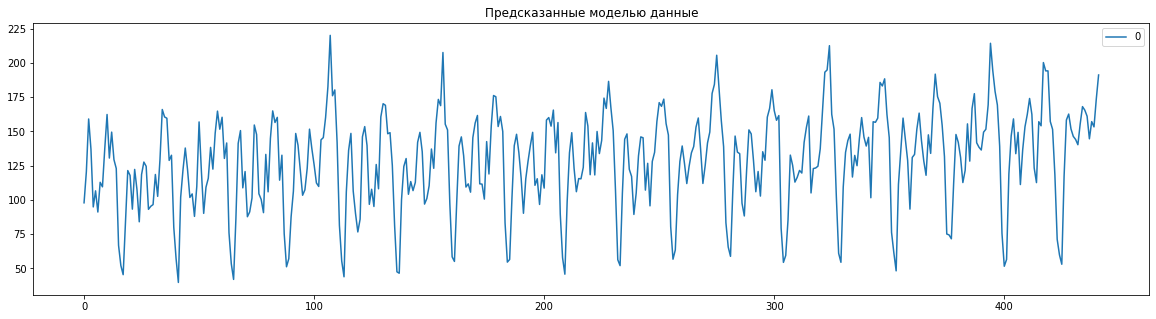

In [206]:
(pd.DataFrame(predictions_cbr1)).plot(figsize=(20, 5), title="Предсказанные моделью данные")

<AxesSubplot:title={'center':'Исходные значения'}, xlabel='datetime'>

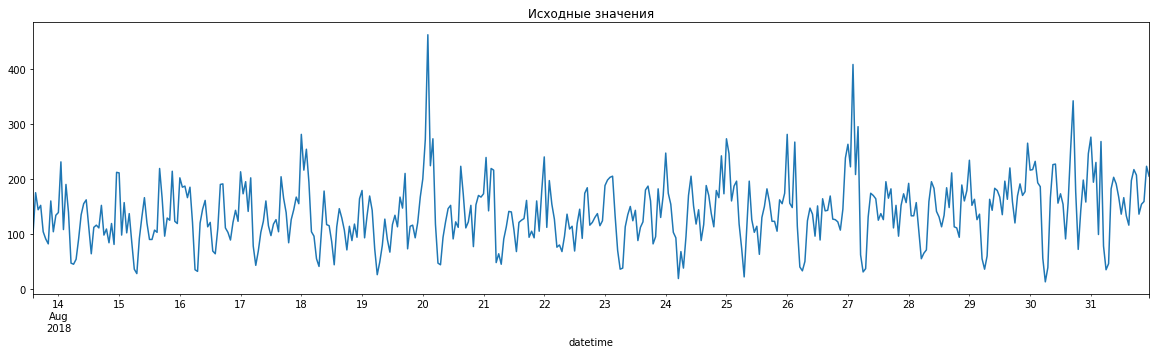

In [207]:
target_test.plot(figsize=(20, 5), title="Исходные значения")

In [209]:
data_target = target_test.to_frame().reset_index()


In [210]:
pred =  pd.DataFrame(predictions_cbr1)


In [229]:
data_merged = data_target.append(pred, ignore_index=True)

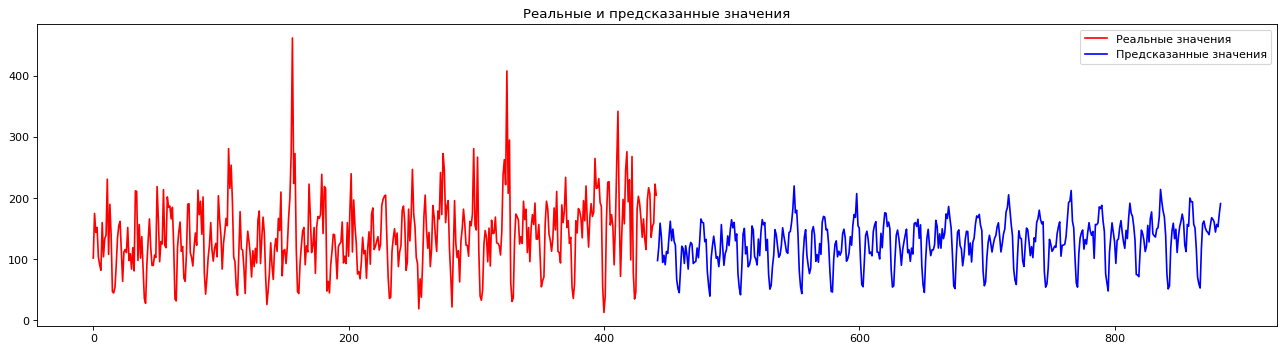

In [250]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 5), dpi=80)
plt.plot(data_merged['num_orders'], 'r-',label='Реальные значения')
plt.plot(data_merged[0], 'b-',label='Предсказанные значения')
plt.title('Реальные и предсказанные значения')
plt.legend()
plt.show()

## Выводы

Нами загружены и обработаны дынные заказов такси за период с 1 марта по 31 августа 2018 года. Данные преобразованы для соответствия формата даты и времени, хронологический порядок в данных соблюден, выполнено ресемплирование данных по одному часу. Имеющиеся данные представляют собой стационарный временной ряд.

Проанализировав данные мы выделелили следующие особенности: существует разница в объемах заказов такси по сезонам, меcяцам, неделям, дням недели, времени суток.

Нами обучено три модели: линейная регрессия, дерево решений для регрессии, CatBoostRegressor, предварительно созданы признаки исходя из выявленных в данных закономерностей, определен целевой признак, тренировочная выборка выделена в размере 10 процентов.

Для всех моделей посчитана метрика RMSE для тренировочной выборки, наилучший результат показала модель CatBoostRegressor - 20.01, которая была проверена на тестовой выборке.

Модель соответсвует критериям, заявленным заказчиком, и может быть использована для прогнозирования количества заказов такси на следующий час.

